

```
# Setup
```

In [ ]:
# ==== 1) GPU & library setup ====
!nvidia-smi -L || true

# Core HF stack
!pip -q install -U "transformers" "datasets" "peft" "accelerate" "evaluate" "sentencepiece" "rouge-score" "huggingface_hub"
!pip -q install -U "bitsandbytes"

import os, random, numpy as np, torch

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

# ==== 2) Login to Hugging Face
from huggingface_hub import login
login()

# ==== 3) constants & seed ====
MODEL_ID   = "amaraaa/mt5-base-summarization-mn-v1"
DATASET_ID = "amaraaa/multi-task_mn_cnn_v02"          # multi-task dataset
NEW_REPO_ID = "amaraaa/mt5-base-multitask-mn-v2"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


GPU 0: Tesla T4 (UUID: GPU-45de47c1-ac59-533f-872b-3dbf5b42f8a1)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 18.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 11.9 MB/s eta 0:00:00
Torch: 2.8.0+cu126
CUDA available: True


Device: cuda


# Sanity-check the dataset

In [ ]:
from datasets import load_dataset, DatasetDict
from pprint import pprint

DATASET_ID = "amaraaa/multi-task_mn_cnn_v02"

# Load all splits
raw_ds: DatasetDict = load_dataset(DATASET_ID)
print(raw_ds)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/689 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/7.61M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/415k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/396k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1862 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/106 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/95 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'article', 'highlights', 'title', 'keywords'],
        num_rows: 1862
    })
    validation: Dataset({
        features: ['id', 'article', 'highlights', 'title', 'keywords'],
        num_rows: 106
    })
    test: Dataset({
        features: ['id', 'article', 'highlights', 'title', 'keywords'],
        num_rows: 95
    })
})


# (task prompts + targets)

In [ ]:
import re

def _clean_spaces(s: str) -> str:
    return re.sub(r"\s+", " ", (s or "")).strip()

def join_highlights(highlights):
    # list[str] -> single summary string
    if not isinstance(highlights, list) or len(highlights) == 0:
        return ""
    return _clean_spaces(" ".join([h.strip() for h in highlights if isinstance(h, str) and h.strip()]))

def join_keywords(keywords):
    # list[str] -> "kw1, kw2, kw3"
    if not isinstance(keywords, list) or len(keywords) == 0:
        return ""
    seen = set()
    kept = []
    for k in keywords:
        k = (k or "").strip()
        if k and k not in seen:
            kept.append(k)
            seen.add(k)
    return ", ".join(kept)

# Optional toggle for stricter titles (keep it False unless you want to enforce single sentence)
ENFORCE_SINGLE_SENTENCE_TITLE = False

def normalize_title(title: str) -> str:
    t = _clean_spaces(title or "")
    if ENFORCE_SINGLE_SENTENCE_TITLE and t:
        parts = re.split(r"(?<=[\.\?\!…])\s+", t, maxsplit=1)
        t = parts[0] if parts else t
    return t


# build per-task datasets (prompt, target)

In [ ]:
from datasets import Dataset, DatasetDict

def make_task_views(ds: DatasetDict):
    """
    Split бүрд дараах багануудтай 3 өөр datasets үүсгэнэ:
      - 'input_text': mT5-style prefixed input (e.g., "summarize: <article>")
      - 'labels'    : target string
      - 'task'      : one of {'summarize','title','keywords'} (for inspection/metrics)
    """
    out = {}

    for split in ds.keys():
        dsplit = ds[split]

        def map_summarize(batch):
            inputs, labels, tasks = [], [], []
            for art, hl in zip(batch["article"], batch["highlights"]):
                tgt = join_highlights(hl)
                if art and tgt:
                    inputs.append(f"summarize: {art}")
                    labels.append(tgt)
                    tasks.append("summarize")
            return {"input_text": inputs, "labels": labels, "task": tasks}

        def map_title(batch):
            inputs, labels, tasks = [], [], []
            for art, ttl in zip(batch["article"], batch["title"]):
                tgt = normalize_title(ttl)
                if art and tgt:
                    inputs.append(f"title: {art}")
                    labels.append(tgt)
                    tasks.append("title")
            return {"input_text": inputs, "labels": labels, "task": tasks}

        def map_keywords(batch):
            inputs, labels, tasks = [], [], []
            for art, kws in zip(batch["article"], batch["keywords"]):
                tgt = join_keywords(kws)
                if art and tgt:
                    inputs.append(f"keywords: {art}")
                    labels.append(tgt)
                    tasks.append("keywords")
            return {"input_text": inputs, "labels": labels, "task": tasks}

        sum_ds = dsplit.map(map_summarize, batched=True, remove_columns=dsplit.column_names)
        ttl_ds = dsplit.map(map_title,      batched=True, remove_columns=dsplit.column_names)
        kw_ds  = dsplit.map(map_keywords,   batched=True, remove_columns=dsplit.column_names)

        out[split] = {"summarize": sum_ds, "title": ttl_ds, "keywords": kw_ds}

    return out

task_views = make_task_views(raw_ds)

for split in ["train","validation","test"]:
    print(f"\n== {split.upper()} counts ==")
    for t in ["summarize","title","keywords"]:
        print(t, len(task_views[split][t]))


Map:   0%|          | 0/1862 [00:00<?, ? examples/s]

Map:   0%|          | 0/1862 [00:00<?, ? examples/s]

Map:   0%|          | 0/1862 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

Map:   0%|          | 0/95 [00:00<?, ? examples/s]


== TRAIN counts ==
summarize 1862
title 1862
keywords 1862

== VALIDATION counts ==
summarize 106
title 106
keywords 106

== TEST counts ==
summarize 95
title 95
keywords 95


# mixture for training

In [ ]:
from datasets import interleave_datasets

# Training харьцаа
RATIO_SUMMARIZE = 1
RATIO_TITLE     = 1
RATIO_KEYWORDS  = 1

def build_mixed_split(task_views, split: str,
                      ratio_s=RATIO_SUMMARIZE, ratio_t=RATIO_TITLE, ratio_k=RATIO_KEYWORDS):
    a = task_views[split]["summarize"]
    b = task_views[split]["title"]
    c = task_views[split]["keywords"]
    total = float(ratio_s + ratio_t + ratio_k)
    probs = [ratio_s/total, ratio_t/total, ratio_k/total]
    return interleave_datasets([a, b, c], stopping_strategy="all_exhausted",)

train_mixed = build_mixed_split(task_views, "train", ratio_s=RATIO_SUMMARIZE, ratio_t=RATIO_TITLE, ratio_k=RATIO_KEYWORDS)

# Validation: 1:1:1
val_mixed     = build_mixed_split(task_views, "validation", ratio_s=1, ratio_t=1, ratio_k=1)
val_summarize = task_views["validation"]["summarize"]
val_title     = task_views["validation"]["title"]
val_keywords  = task_views["validation"]["keywords"]

print(train_mixed)
print(val_mixed)
print("val per-task sizes:", len(val_summarize), len(val_title), len(val_keywords))


Dataset({
    features: ['input_text', 'labels', 'task'],
    num_rows: 5586
})
Dataset({
    features: ['input_text', 'labels', 'task'],
    num_rows: 318
})
val per-task sizes: 106 106 106


# Сургалтад ашиглах mixed dataset -ээ шалгана



In [ ]:
for i in range(3):
    ex = train_mixed[i]
    print(f"\n[{i}] task={ex['task']}")
    print("INPUT :", ex["input_text"][:220], "...")
    print("TARGET:", ex["labels"][:220], "...")



[0] task=summarize
INPUT : summarize: . Ричард Спиллетт. Машинд цэнэглэж байх үед дэлбэрсэн электрон тамхи нь бүтээгдэхүүний аюулгүй байдлын талаар шинэ айдас төрүүлэв. 54 настай асран хамгаалагч Ким Тейлор машинаас гал болон өтгөн хар утаа гарч б ...
TARGET: 54 настай Ким Тейлор төхөөрөмжөө Ford Mondeo машины арын суудалд залгаад орхижээ. Гэвч тэр хэдхэн минутын дараа буцаж ирээд машинаас утаа гарч байгааг харав. Түүний хэлснээр төхөөрөмж дэлбэрч, машины суудалд нь асар том  ...

[1] task=title
INPUT : title: . Ричард Спиллетт. Машинд цэнэглэж байх үед дэлбэрсэн электрон тамхи нь бүтээгдэхүүний аюулгүй байдлын талаар шинэ айдас төрүүлэв. 54 настай асран хамгаалагч Ким Тейлор машинаас гал болон өтгөн хар утаа гарч байга ...
TARGET: 54 настай Ким Тейлор төхөөрөмжөө Ford Mondeo машины арын суудалд залгаад орхижээ ...

[2] task=keywords
INPUT : keywords: . Ричард Спиллетт. Машинд цэнэглэж байх үед дэлбэрсэн электрон тамхи нь бүтээгдэхүүний аюулгүй байдлын талаар шинэ айдас төрүүлэв. 54 н

# tokenizer and tokenization

In [ ]:
from transformers import AutoTokenizer

MODEL_ID = "amaraaa/mt5-base-summarization-mn-v1"

# mT5 tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)

#length
MAX_SOURCE_LEN = 768
MAX_TARGET_LEN = 160

def tokenize_examples(batch):
    # inputs
    enc = tokenizer(
        batch["input_text"],
        max_length=MAX_SOURCE_LEN,
        truncation=True,
        padding=False,
    )
    # targets
    with tokenizer.as_target_tokenizer():
        dec = tokenizer(
            batch["labels"],
            max_length=MAX_TARGET_LEN,
            truncation=True,
            padding=False,
        )
    enc["labels"] = dec["input_ids"]
    return enc

# Tokenize training (mixed) and validation (mixed + per-task)
tok_train = train_mixed.map(tokenize_examples, batched=True, remove_columns=train_mixed.column_names)
tok_val_mixed = val_mixed.map(tokenize_examples, batched=True, remove_columns=val_mixed.column_names)

# Optional: task-specific validation sets for separate metrics later
tok_val_sum = val_summarize.map(tokenize_examples, batched=True, remove_columns=val_summarize.column_names)
tok_val_ttl = val_title.map(tokenize_examples,      batched=True, remove_columns=val_title.column_names)
tok_val_kw  = val_keywords.map(tokenize_examples,   batched=True, remove_columns=val_keywords.column_names)

print(tok_train)
print(tok_val_mixed)


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/416 [00:00<?, ?B/s]

Map:   0%|          | 0/5586 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/318 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 5586
})
Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 318
})


8-bit model load + LoRA attach

In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM, BitsAndBytesConfig
from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training

# 8-bit quantization config (bitsandbytes)
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,          # memory-optimized 8-bit base
    llm_int8_threshold=6.0,     # default is fine; keeps higher-variance channels in fp16
)

# Load base model in 8-bit with device_map auto
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
)

base_model = prepare_model_for_kbit_training(base_model)

# LoRA config
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.15,
    target_modules=["q", "v"],
    bias="none",
)

model = get_peft_model(base_model, lora_config)

model.config.use_cache = False

# trainable vs total parameters
def print_trainable_parameters(m):
    trainable = 0
    total = 0
    for _, p in m.named_parameters():
        total += p.numel()
        if p.requires_grad:
            trainable += p.numel()
    pct = 100 * trainable / total
    print(f"Trainable params: {trainable:,} / {total:,} ({pct:.2f}%)")

print_trainable_parameters(model)


config.json:   0%|          | 0.00/783 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

Trainable params: 884,736 / 583,286,016 (0.15%)


In [ ]:
# 2) Sentinel blocklist үүсгэх (T5 extra_id 0..99) -> for generation
vsize = tokenizer.vocab_size
extra_ids = list(range(vsize - 100, vsize))
bad_words_ids = [[i] for i in extra_ids]
print(f"Blocking {len(bad_words_ids)} sentinel IDs: {extra_ids[0]}..{extra_ids[-1]}")

# After building bad_words_ids
model.generation_config.bad_words_ids = bad_words_ids

Blocking 100 sentinel IDs: 250000..250099


# Colab cell — data collator

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding="longest",
    label_pad_token_id=-100,  # ignored by loss
)


# Metrics (ROUGE on decoded predictions)

In [ ]:
import evaluate
import numpy as np
from typing import List, Dict

#1) Metric: ROUGE
rouge = evaluate.load("rouge")

def postprocess_text(preds, labels):
  # strip хийгээд sentence хоороod newline нэмэх
  preds = [p.strip() for p in preds]
  labels = [l.strip() for l in labels]
  return preds, labels

def compute_metrics(eval_pred):
  preds, labels = eval_pred

  # Some trainers return (sequences)
  if isinstance(preds, tuple):
      preds = preds[0] #take token IDs matrix

  # IMPORTANT: decode хийхээс өмнө ignore index (-100) -г real pad token ID -аар солих
  #preds
  if isinstance(preds, np.ndarray):
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
  else:
    # fallback in case preds is a list
    preds = [[(tok if tok != -100 else tokenizer.pad_token_id) for tok in seq] for seq in preds]
  #labels
  if isinstance(labels, np.ndarray):
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  else:
    # fallback in case labels is a list
    labels = [[(tok if tok != -100 else tokenizer.pad_token_id) for tok in seq] for seq in labels]

  # decode predictions
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  # print(decoded_preds) # Debugging line, uncomment if needed

  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # light cleanup for ROUGE
  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

  # Compute ROUGE
  result = rouge.compute(
      predictions=decoded_preds,
      references=decoded_labels,
      use_stemmer=True,
  )

  return {k: round(v * 100, 4) for k, v in result.items()}


# Training arguments

In [ ]:
from transformers import Seq2SeqTrainingArguments

SCHEDULER = "linear"
WARMUP_RATIO = 0.06 if SCHEDULER in {"linear", "cosine"} else 0.10

OUTPUT_DIR = "mt5_multitask_mn_lora"

TRAIN_EPOCHS = 6
PER_DEVICE_TRAIN_BS = 16     # T4-friendly with 8-bit base and LoRA
PER_DEVICE_EVAL_BS  = 16
GRAD_ACCUM_STEPS    = 2     # effective train batch size = 16 * 2 = 32

LEARNING_RATE = 1e-4        # LoRA-friendly LR for small dataset -> 2e-4
WEIGHT_DECAY  = 0.0         # usually 0 for LoRA
BEAMS         = 4
MAX_GEN_LEN   = 160

training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BS,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BS,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    num_train_epochs=TRAIN_EPOCHS,
    lr_scheduler_type=SCHEDULER,
    warmup_ratio=WARMUP_RATIO,

    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_rougeLsum",
    greater_is_better=True,

    predict_with_generate=True,
    generation_max_length=MAX_GEN_LEN,
    generation_num_beams=BEAMS,
    dataloader_num_workers=2,
    dataloader_pin_memory=True,

    fp16=False,
    logging_steps=50,
    report_to="none",
)


# Enable gradient checkpointing & build the Trainer

In [ ]:
from transformers import Seq2SeqTrainer
from transformers.trainer_callback import EarlyStoppingCallback

# Enable gradient checkpointing to reduce memory pressure
model.gradient_checkpointing_enable()
model.config.use_cache = False  # important when using gradient checkpointing

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tok_train,
    eval_dataset=tok_val_mixed,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=2)  # stop if no improvement in rougeL
    ],
)

# Quick sanity check
batch = next(iter(trainer.get_train_dataloader()))
with torch.no_grad():
    _ = model(
        input_ids=batch["input_ids"].to(model.device),
        attention_mask=batch["attention_mask"].to(model.device),
        labels=batch["labels"].to(model.device),
    )
print("Sanity forward pass OK.")


/tmp/ipython-input-38488466.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Sanity forward pass OK.


In [ ]:
small_eval = tok_val_mixed.select(range(10))
eval_result = trainer.evaluate(eval_dataset=small_eval)

print(eval_result)

/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


{'eval_loss': 2.803279399871826, 'eval_model_preparation_time': 0.0029, 'eval_rouge1': 6.8182, 'eval_rouge2': 0.0, 'eval_rougeL': 6.8182, 'eval_rougeLsum': 6.8182, 'eval_runtime': 22.5505, 'eval_samples_per_second': 0.443, 'eval_steps_per_second': 0.044}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Start training and save the adapter

In [ ]:
# Training эхлүүлэх
train_out = trainer.train()
print(train_out)

# best LoRA adapter -ийг хадгалах
ADAPTER_DIR = "mt5_multitask_mn_lora_adapter"
model.save_pretrained(ADAPTER_DIR)
tokenizer.save_pretrained(ADAPTER_DIR)

# Quick note showing where artifacts are stored
import os, glob
print("Saved adapter files:", glob.glob(os.path.join(ADAPTER_DIR, "*"))[:10])


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.966800,2.401083,7.692900,1.361300,7.742800,7.768500
2,2.871200,2.344651,8.236300,1.145800,8.395100,8.310500
3,2.831800,2.324528,8.356000,1.439000,8.458800,8.390300
4,2.836100,2.304369,8.249500,1.501800,8.317100,8.265900
5,2.800900,2.300039,8.010700,1.112300,8.032200,8.040000


/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during q

TrainOutput(global_step=875, training_loss=2.8923607875279016, metrics={'train_runtime': 11291.0762, 'train_samples_per_second': 2.968, 'train_steps_per_second': 0.093, 'total_flos': 5.034790448529408e+16, 'train_loss': 2.8923607875279016, 'epoch': 5.0})
Saved adapter files: ['mt5_multitask_mn_lora_adapter/spiece.model', 'mt5_multitask_mn_lora_adapter/special_tokens_map.json', 'mt5_multitask_mn_lora_adapter/tokenizer_config.json', 'mt5_multitask_mn_lora_adapter/tokenizer.json', 'mt5_multitask_mn_lora_adapter/adapter_config.json', 'mt5_multitask_mn_lora_adapter/adapter_model.safetensors', 'mt5_multitask_mn_lora_adapter/README.md']


In [ ]:
#==================================

In [ ]:
# Сургасан model -оо хадгалах

#1) Google Drive -руу хадгалах
SAVE_DIR = "/content/drive/MyDrive/mt5_base_multitask_finetuned_v1"

from google.colab import drive
drive.mount('/content/drive')

trainer.save_model(SAVE_DIR) # with PEFT: saves LoRA adapter + peft_config.json
tokenizer.save_pretrained(SAVE_DIR) # tokenizer files
model.config.save_pretrained(SAVE_DIR)
print("Saved to:", SAVE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved to: /content/drive/MyDrive/mt5_base_multitask_finetuned_v1


# ROUGE per task

In [ ]:
# Uses the same compute_metrics() defined earlier (ROUGE on decoded text)
sum_metrics = trainer.evaluate(eval_dataset=tok_val_sum,  metric_key_prefix="val_sum")
ttl_metrics = trainer.evaluate(eval_dataset=tok_val_ttl,  metric_key_prefix="val_title")
kw_metrics  = trainer.evaluate(eval_dataset=tok_val_kw,   metric_key_prefix="val_kw")

print("\n[ROUGE] Validation — Summarization:", {k: round(v, 4) for k,v in sum_metrics.items() if k.startswith("val_sum")})
print("[ROUGE] Validation — Title        :", {k: round(v, 4) for k,v in ttl_metrics.items() if k.startswith("val_title")})
print("[ROUGE] Validation — Keywords     :", {k: round(v, 4) for k,v in kw_metrics.items() if k.startswith("val_kw")})


/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


early stopping required metric_for_best_model, but did not find eval_rougeLsum so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_rougeLsum so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_rougeLsum so early stopping is disabled



[ROUGE] Validation — Summarization: {'val_sum_loss': 2.1057, 'val_sum_rouge1': 14.0902, 'val_sum_rouge2': 2.9412, 'val_sum_rougeL': 14.2669, 'val_sum_rougeLsum': 14.3673, 'val_sum_runtime': 168.9149, 'val_sum_samples_per_second': 0.628, 'val_sum_steps_per_second': 0.041}
[ROUGE] Validation — Title        : {'val_title_loss': 2.0965, 'val_title_rouge1': 4.4025, 'val_title_rouge2': 0.566, 'val_title_rougeL': 4.3239, 'val_title_rougeLsum': 4.3239, 'val_title_runtime': 164.818, 'val_title_samples_per_second': 0.643, 'val_title_steps_per_second': 0.042}
[ROUGE] Validation — Keywords     : {'val_kw_loss': 2.8302, 'val_kw_rouge1': 6.6449, 'val_kw_rouge2': 0.9434, 'val_kw_rougeL': 6.6024, 'val_kw_rougeLsum': 6.7963, 'val_kw_runtime': 159.4043, 'val_kw_samples_per_second': 0.665, 'val_kw_steps_per_second': 0.044}


# Merge LoRA → base weights locally and self-test

In [ ]:
from peft import PeftConfig
from pathlib import Path

ADAPTER_DIR = "mt5_multitask_mn_lora_adapter"     # <-- change if yours is different
MERGED_DIR  = "mt5_multitask_merged"

peft_cfg = PeftConfig.from_pretrained(ADAPTER_DIR)
BASE_ID = peft_cfg.base_model_name_or_path
print("Base model recorded in adapter:", BASE_ID)
Path(MERGED_DIR).mkdir(parents=True, exist_ok=True)

Base model recorded in adapter: amaraaa/mt5-base-summarization-mn-v1


# Load base, attach adapter, merge and unload

In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import PeftModel

def pick_dtype():
    if torch.cuda.is_available():
        major, _ = torch.cuda.get_device_capability(0)
        return torch.bfloat16 if major >= 8 else torch.float16  # bf16 on Ampere+; else fp16
    return torch.float32

dtype = pick_dtype()

base = AutoModelForSeq2SeqLM.from_pretrained(BASE_ID, torch_dtype=dtype)
tok  = AutoTokenizer.from_pretrained(ADAPTER_DIR)  # prefer your saved tokenizer
model = PeftModel.from_pretrained(base, ADAPTER_DIR)

# The key step:
merged = model.merge_and_unload()   # applies LoRA deltas into base weights in-place
merged.eval()

`torch_dtype` is deprecated! Use `dtype` instead!


MT5ForConditionalGeneration(
  (shared): Embedding(250112, 768)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
         

# Save merged model (+ tokenizer + generation config)

In [ ]:
# Save weights/config
merged.save_pretrained(MERGED_DIR)

# Tokenizer
tok.save_pretrained(MERGED_DIR)

# Generation config (if present on the current model)
try:
    merged.generation_config.save_pretrained(MERGED_DIR)
    print("Saved generation_config.json")
except Exception as e:
    print("No generation_config to save:", e)

Saved generation_config.json


In [ ]:
import os, glob
MERGED_DIR = "mt5_multitask_merged"  # or whatever you used above
print("cwd:", os.getcwd())
print("exists:", os.path.isdir(MERGED_DIR))
print("contents (first 20):")
for p in sorted(glob.glob(f"{MERGED_DIR}/**/*", recursive=True))[:20]:
    print(" ", p)


cwd: /content
exists: True
contents (first 20):
  mt5_multitask_merged/config.json
  mt5_multitask_merged/generation_config.json
  mt5_multitask_merged/model.safetensors
  mt5_multitask_merged/special_tokens_map.json
  mt5_multitask_merged/spiece.model
  mt5_multitask_merged/tokenizer.json
  mt5_multitask_merged/tokenizer_config.json


In [ ]:
# Either CLI (in a notebook cell)
# !huggingface-cli login

# Or Python:
from huggingface_hub import login
login()  # paste your HF token from https://huggingface.co/settings/tokens

In [ ]:
from huggingface_hub import upload_folder

repo_id = "amaraaa/multitask-mt5-base-mn-v1"
upload_folder(
    repo_id=repo_id,
    folder_path=MERGED_DIR,
    commit_message="Add merged mT5 Mongolian multitask model",
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ask_merged/tokenizer.json:   3%|3         |  512kB / 16.3MB            

  ...itask_merged/spiece.model: 100%|##########| 4.31MB / 4.31MB            

  ..._merged/model.safetensors:   2%|2         | 25.1MB / 1.24GB            

CommitInfo(commit_url='https://huggingface.co/amaraaa/multitask-mt5-base-mn-v1/commit/9bf610b7e6dbab76c382aa6b3bff056e52476dbe', commit_message='Add merged mT5 Mongolian multitask model', commit_description='', oid='9bf610b7e6dbab76c382aa6b3bff056e52476dbe', pr_url=None, repo_url=RepoUrl('https://huggingface.co/amaraaa/multitask-mt5-base-mn-v1', endpoint='https://huggingface.co', repo_type='model', repo_id='amaraaa/multitask-mt5-base-mn-v1'), pr_revision=None, pr_num=None)

# График харуулах (loss, epoch)

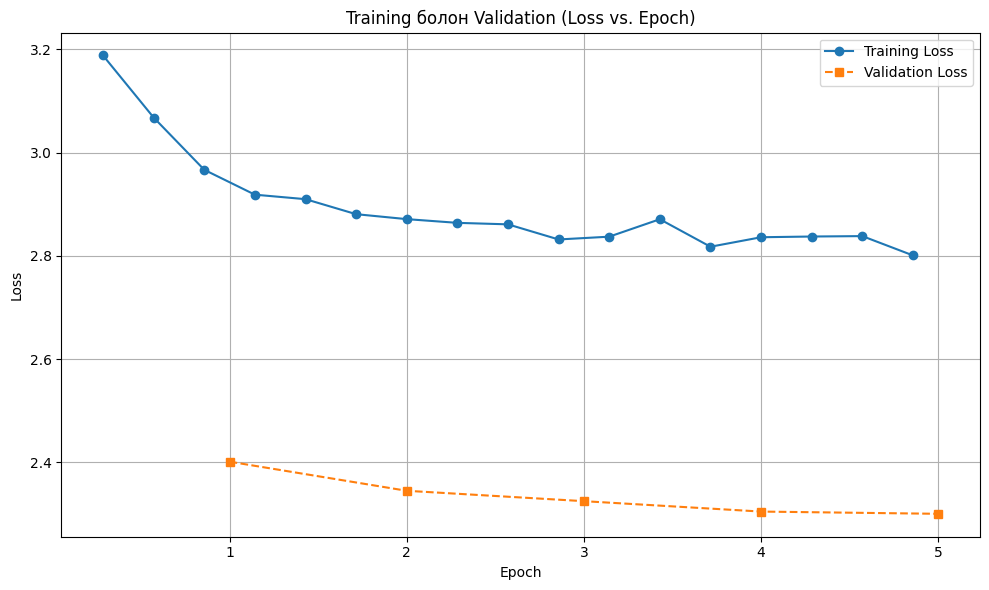

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# fine-tuning дууссаны дараа
def plot_training_loss(trainer):
    """
    Trainer object -ийн history -гоос (training loss/ validation loss) -ийг авах
    """
    # Extract the log history from the trainer state
    history = trainer.state.log_history

    # Convert history list to a pandas DataFrame for easier manipulation
    df = pd.DataFrame(history)

    # Filter for training loss entries
    # The key names might vary slightly ('loss', 'train_loss', 'eval_loss', etc.)
    train_loss_df = df.dropna(subset=['loss'])

    # Filter for validation loss entries
    eval_loss_df = df.dropna(subset=['eval_loss'])

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot training loss
    if not train_loss_df.empty:
        plt.plot(train_loss_df['epoch'], train_loss_df['loss'], label='Training Loss', marker='o', linestyle='-')

    # Plot validation loss
    if not eval_loss_df.empty:
        # We need to map evaluation steps to the correct epoch values
        plt.plot(eval_loss_df['epoch'], eval_loss_df['eval_loss'], label='Validation Loss', marker='s', linestyle='--')

    plt.title('Training болон Validation (Loss vs. Epoch)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- How to use it ---
# After you run your trainer.train() command, call the function:

# Example usage (commented out as the trainer object is not defined here):
plot_training_loss(trainer)
